# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Options

In [2]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)
    train_feats = [var for x in train_feats for var in train_feats[x]]

In [3]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [4]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [5]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                             reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


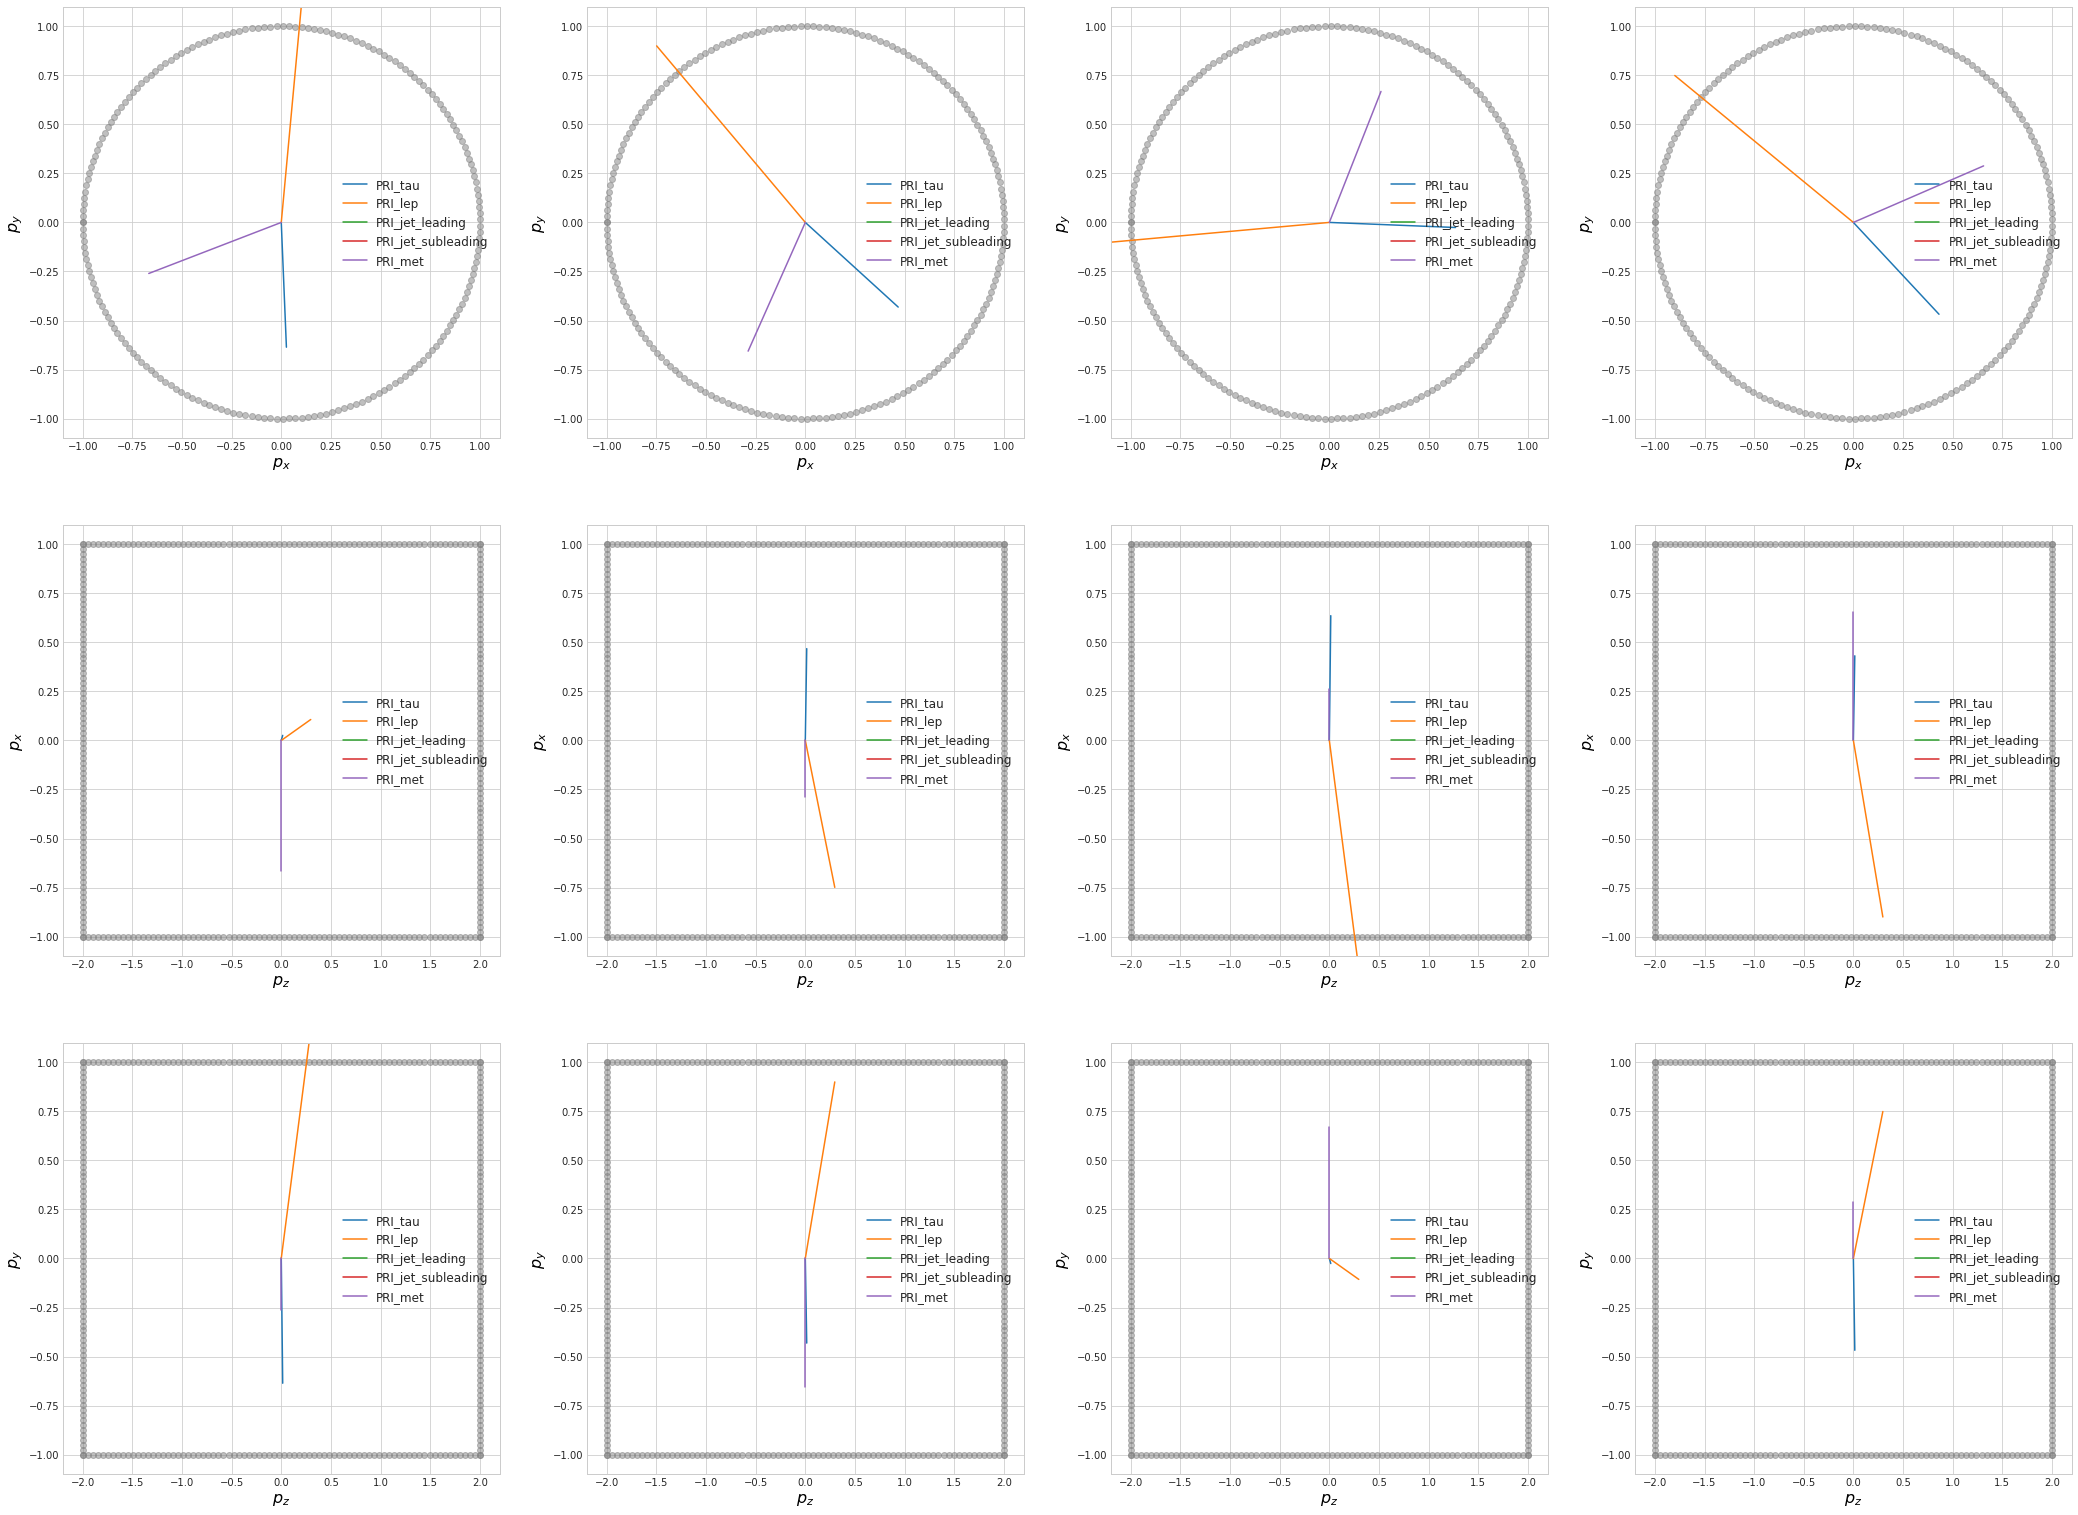

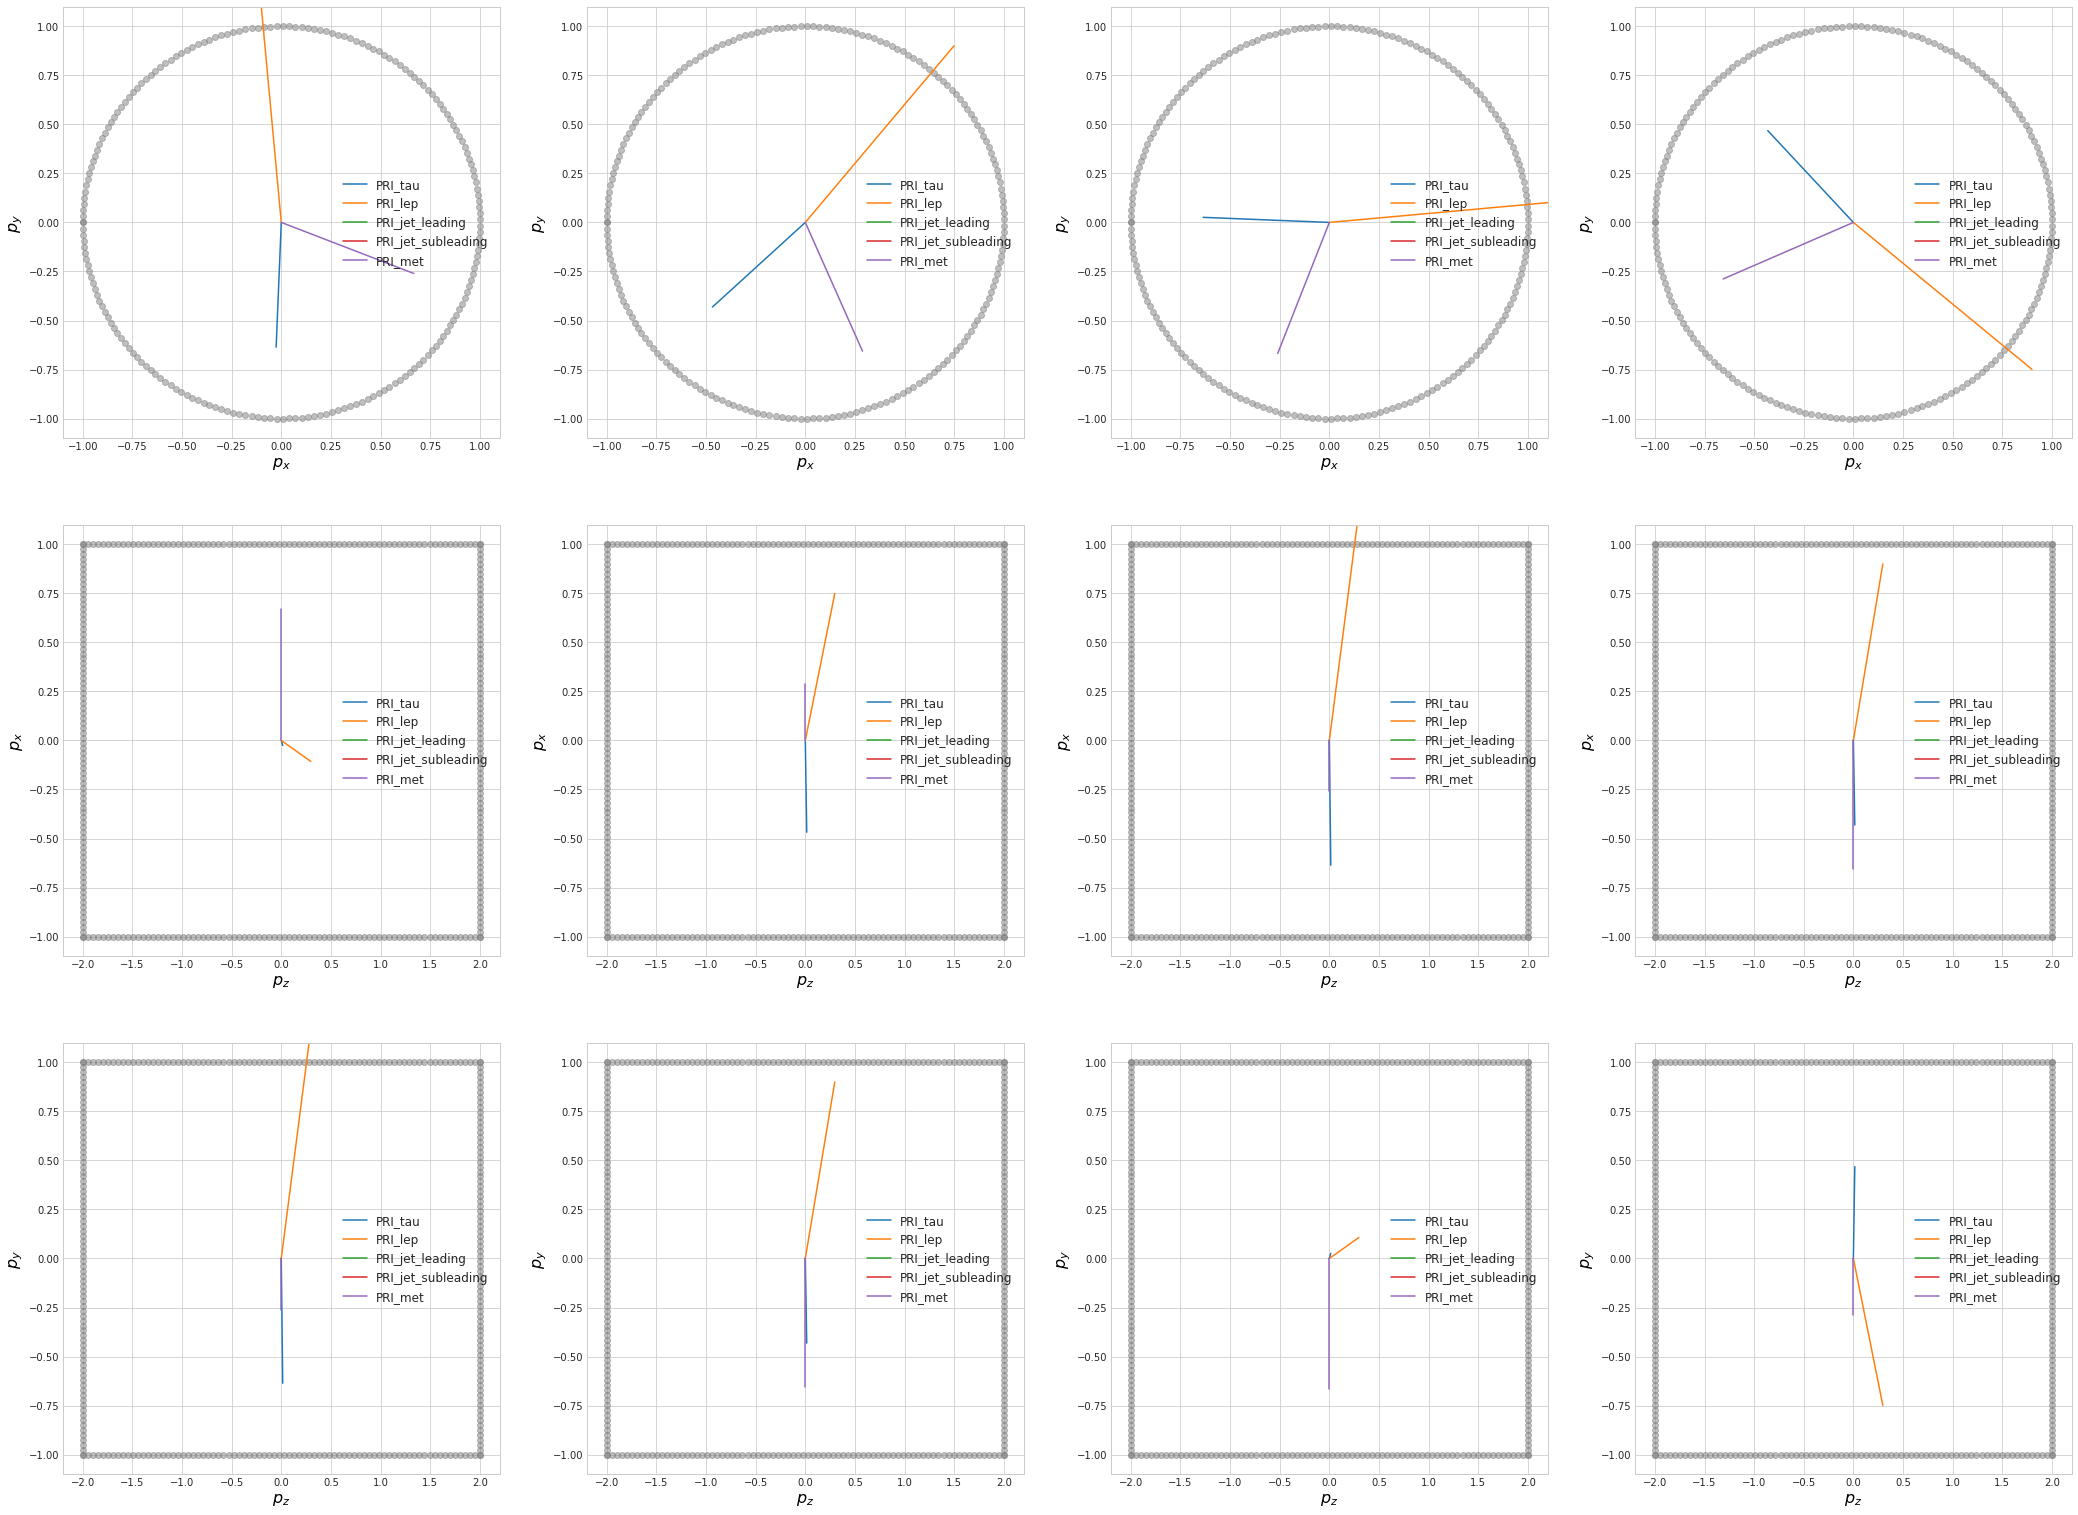

In [6]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    comp_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

## Determine LR

2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 18.467s 


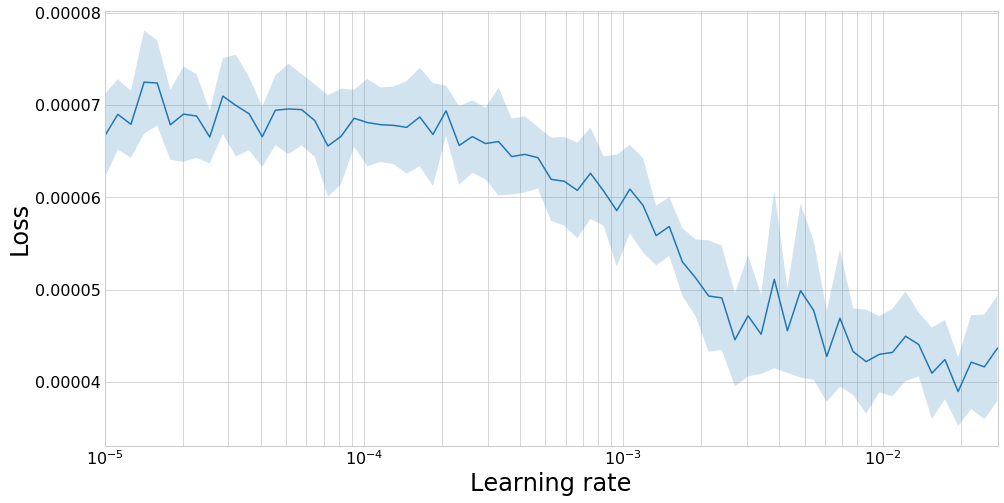

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [8]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.121830). Check your callbacks.
  % delta_t_median)


1 New best found: 3.944666521897876e-05
2 New best found: 3.611978467994269e-05
3 New best found: 3.539067692558067e-05
5 New best found: 3.4333260524598075e-05
6 New best found: 3.356512013014575e-05
7 New best found: 3.343260355715565e-05
11 New best found: 3.314639853509144e-05
12 New best found: 3.2725814866988673e-05
13 New best found: 3.2552418202172954e-05
14 New best found: 3.2463106470961e-05
24 New best found: 3.240019084107971e-05
25 New best found: 3.221080690249116e-05
26 New best found: 3.21352453048291e-05
27 New best found: 3.203614668481301e-05
28 New best found: 3.199247169207532e-05
29 New best found: 3.193115367515721e-05
30 New best found: 3.190689832680239e-05
31 New best found: 3.190440852286648e-05
49 New best found: 3.1810955567177044e-05
52 New best found: 3.181047435584511e-05
53 New best found: 3.178509505158214e-05
54 New best found: 3.177000596256086e-05
55 New best found: 3.1692977057664106e-05
56 New best found: 3.166609827636699e-05
57 New best found: 3

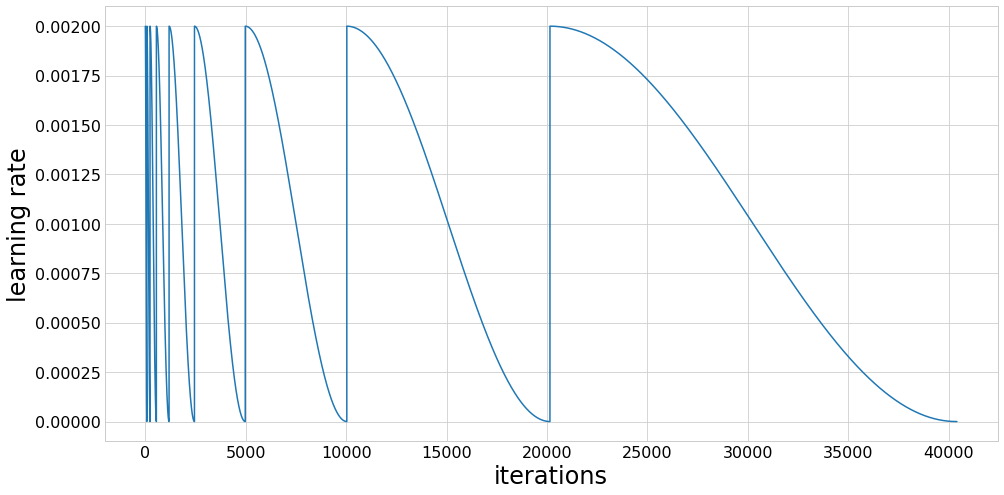

Fold took 593.272s

Training model 2 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258899). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.129789). Check your callbacks.
  % delta_t_median)


1 New best found: 4.119074774453574e-05
2 New best found: 3.6619553518944394e-05
3 New best found: 3.600599072312751e-05
4 New best found: 3.599928360149131e-05
5 New best found: 3.537839835391252e-05
6 New best found: 3.47979980196872e-05
7 New best found: 3.4567236185017713e-05
9 New best found: 3.453459436077811e-05
10 New best found: 3.4376895905678574e-05
11 New best found: 3.41211288415213e-05
12 New best found: 3.388172965395477e-05
13 New best found: 3.373635005323932e-05
14 New best found: 3.362854809336813e-05
15 New best found: 3.361734885729509e-05
22 New best found: 3.3480359306866376e-05
25 New best found: 3.3349841188199705e-05
26 New best found: 3.31631057816785e-05
28 New best found: 3.314660993560417e-05
29 New best found: 3.311618262413789e-05
30 New best found: 3.310811704148641e-05
31 New best found: 3.310315486113204e-05
47 New best found: 3.307483318102046e-05
49 New best found: 3.3048680063712374e-05
50 New best found: 3.2977109572285604e-05
52 New best found: 3

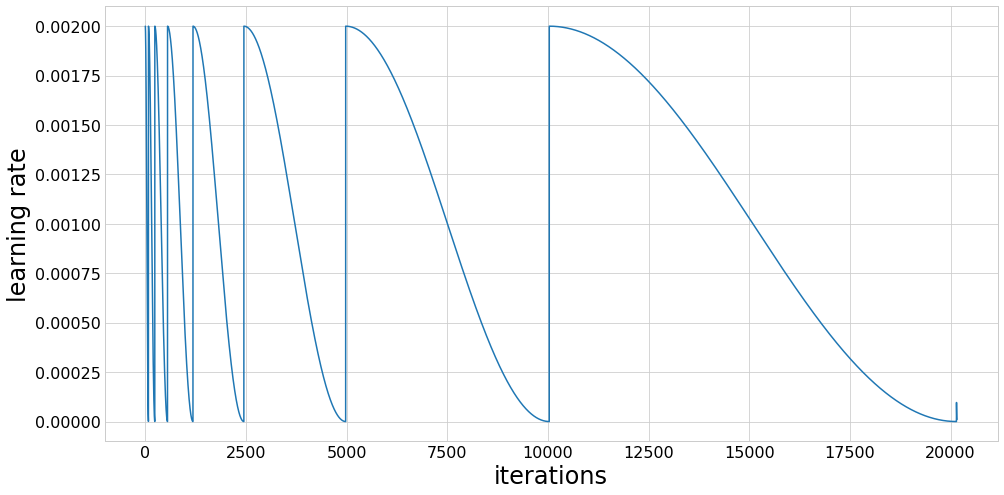

Fold took 293.977s

Training model 3 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285306). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.142989). Check your callbacks.
  % delta_t_median)


1 New best found: 4.087707715079887e-05
2 New best found: 3.714818153239321e-05
3 New best found: 3.646829141798662e-05
4 New best found: 3.601130346942227e-05
5 New best found: 3.523990247340407e-05
6 New best found: 3.462947030784562e-05
7 New best found: 3.448783534549875e-05
10 New best found: 3.417588649899699e-05
11 New best found: 3.4058630622166674e-05
12 New best found: 3.393735572171863e-05
13 New best found: 3.368223339493852e-05
14 New best found: 3.3573973573220426e-05
15 New best found: 3.351851464249194e-05
22 New best found: 3.3415214203705545e-05
23 New best found: 3.340552183653927e-05
24 New best found: 3.333819788240362e-05
25 New best found: 3.325442321947776e-05
26 New best found: 3.314813920733286e-05
27 New best found: 3.29930993670132e-05
28 New best found: 3.299014517979231e-05
29 New best found: 3.289640170551138e-05
47 New best found: 3.289003473764751e-05
49 New best found: 3.2810760801658034e-05
50 New best found: 3.2805491171893666e-05
51 New best found: 

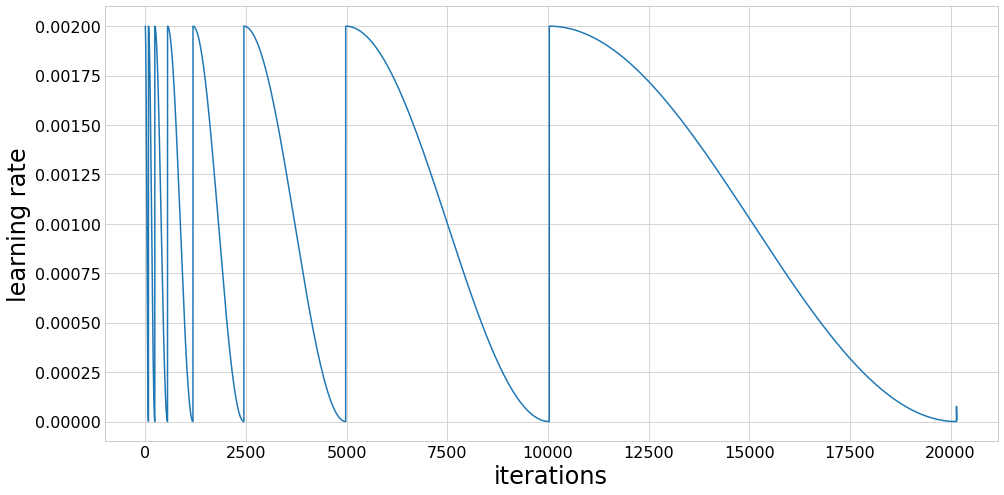

Fold took 292.371s

Training model 4 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.303456). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.152123). Check your callbacks.
  % delta_t_median)


1 New best found: 4.059714121394791e-05
2 New best found: 3.693648416956421e-05
3 New best found: 3.634272408962716e-05
4 New best found: 3.6121099547017367e-05
5 New best found: 3.53901382201002e-05
6 New best found: 3.495181112230057e-05
7 New best found: 3.48851217320771e-05
9 New best found: 3.467190558440052e-05
11 New best found: 3.42838752490934e-05
13 New best found: 3.3997920519323086e-05
14 New best found: 3.394298277999042e-05
15 New best found: 3.3937764361326116e-05
23 New best found: 3.371836996229831e-05
25 New best found: 3.3648019886459226e-05
26 New best found: 3.363266083179042e-05
27 New best found: 3.343268318276387e-05
28 New best found: 3.339784810814308e-05
29 New best found: 3.334350667573745e-05
30 New best found: 3.331020858604461e-05
50 New best found: 3.329409992002184e-05
51 New best found: 3.327760919200955e-05
52 New best found: 3.315952928824117e-05
53 New best found: 3.308027964521898e-05
55 New best found: 3.2999878536793404e-05
56 New best found: 3.2

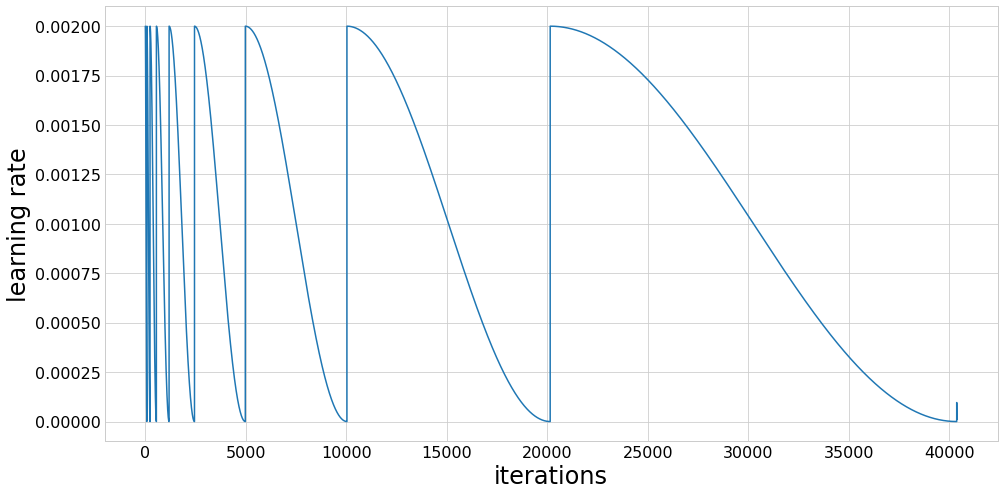

Fold took 580.468s

Training model 5 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.358847). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.179826). Check your callbacks.
  % delta_t_median)


1 New best found: 3.965065458265769e-05
2 New best found: 3.581059578857698e-05
3 New best found: 3.493371466568186e-05
4 New best found: 3.426249777673082e-05
6 New best found: 3.348233873676844e-05
7 New best found: 3.3371133012529786e-05
11 New best found: 3.2911642304968446e-05
12 New best found: 3.2572490167402306e-05
13 New best found: 3.244499961159199e-05
14 New best found: 3.2360639022243177e-05
15 New best found: 3.2359965929990066e-05
22 New best found: 3.224220509523969e-05
25 New best found: 3.2224782224158936e-05
26 New best found: 3.214216989912093e-05
27 New best found: 3.204851184372387e-05
28 New best found: 3.2047579516457954e-05
29 New best found: 3.196034204867896e-05
30 New best found: 3.1930356578830584e-05
31 New best found: 3.192513169271299e-05
48 New best found: 3.1887696212736775e-05
50 New best found: 3.184051741307576e-05
53 New best found: 3.178892508279259e-05
54 New best found: 3.1750781676009015e-05
56 New best found: 3.1715829304767785e-05
57 New best

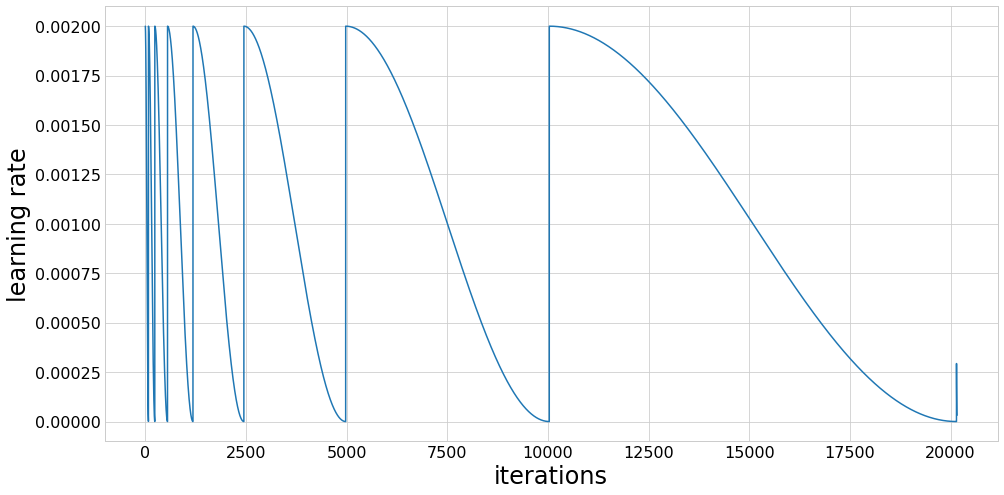

Fold took 303.015s

Training model 6 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.375418). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.188095). Check your callbacks.
  % delta_t_median)


1 New best found: 4.028270489361603e-05
2 New best found: 3.5871310941001865e-05
3 New best found: 3.508740436518565e-05
4 New best found: 3.462709097075276e-05
5 New best found: 3.3907270934287225e-05
6 New best found: 3.3548290334874765e-05
7 New best found: 3.3414889575942655e-05
11 New best found: 3.305086167310947e-05
12 New best found: 3.294352208904456e-05
13 New best found: 3.274669915990671e-05
14 New best found: 3.2708621499477885e-05
15 New best found: 3.267784141207813e-05
23 New best found: 3.259802681714063e-05
24 New best found: 3.24841802881565e-05
26 New best found: 3.220366251698579e-05
28 New best found: 3.216672683120123e-05
29 New best found: 3.211459544691024e-05
30 New best found: 3.211400570726255e-05
31 New best found: 3.2111813259689374e-05
52 New best found: 3.198807067747111e-05
53 New best found: 3.192665609240066e-05
56 New best found: 3.1887761605321426e-05
58 New best found: 3.1848228562739675e-05
61 New best found: 3.1840467203437586e-05
62 New best fou

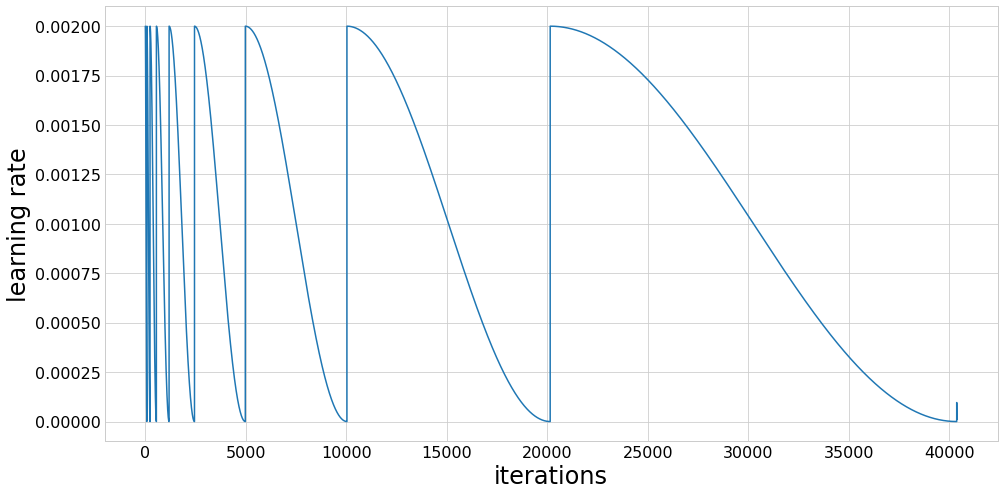

Fold took 592.208s

Training model 7 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408159). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.204579). Check your callbacks.
  % delta_t_median)


1 New best found: 4.1276349941140893e-05
2 New best found: 3.703564384300296e-05
3 New best found: 3.652461736953673e-05
4 New best found: 3.575588808911177e-05
5 New best found: 3.510830305651517e-05
6 New best found: 3.503975640631339e-05
7 New best found: 3.473466934378077e-05
10 New best found: 3.438774329145426e-05
11 New best found: 3.4327202538695036e-05
12 New best found: 3.414146679027568e-05
13 New best found: 3.3891392782445374e-05
14 New best found: 3.380324508530193e-05
15 New best found: 3.37511957603142e-05
23 New best found: 3.3652110732193674e-05
24 New best found: 3.3540766139020634e-05
25 New best found: 3.349428112576615e-05
26 New best found: 3.3412796750032756e-05
27 New best found: 3.3350207084207696e-05
28 New best found: 3.330711762660567e-05
29 New best found: 3.3253635210466185e-05
30 New best found: 3.3248623218007004e-05
31 New best found: 3.324657020068659e-05
50 New best found: 3.314860633432132e-05
52 New best found: 3.297300917702127e-05
55 New best fou

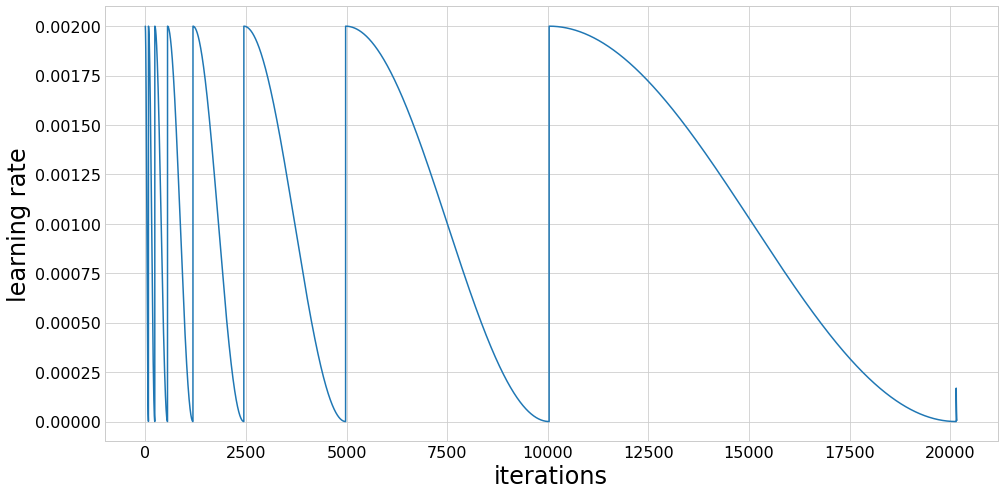

Fold took 317.909s

Training model 8 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.425484). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.213137). Check your callbacks.
  % delta_t_median)


1 New best found: 4.020050009314469e-05
2 New best found: 3.652914721248577e-05
3 New best found: 3.597509697358724e-05
4 New best found: 3.494684070320967e-05
5 New best found: 3.4771028942185165e-05
6 New best found: 3.417970951377154e-05
7 New best found: 3.394507554929659e-05
10 New best found: 3.3724165530832664e-05
11 New best found: 3.3575396648119666e-05
12 New best found: 3.3152103829222804e-05
13 New best found: 3.310188944886475e-05
14 New best found: 3.301542505252013e-05
15 New best found: 3.299481640714039e-05
21 New best found: 3.2771007377952357e-05
24 New best found: 3.2513280304749415e-05
27 New best found: 3.247481571968393e-05
28 New best found: 3.236490463145973e-05
29 New best found: 3.230815047199413e-05
30 New best found: 3.2307003803755793e-05
48 New best found: 3.222911033410286e-05
50 New best found: 3.209438182577725e-05
51 New best found: 3.201677868599067e-05
52 New best found: 3.200699541104656e-05
53 New best found: 3.1964569099163717e-05
55 New best fou

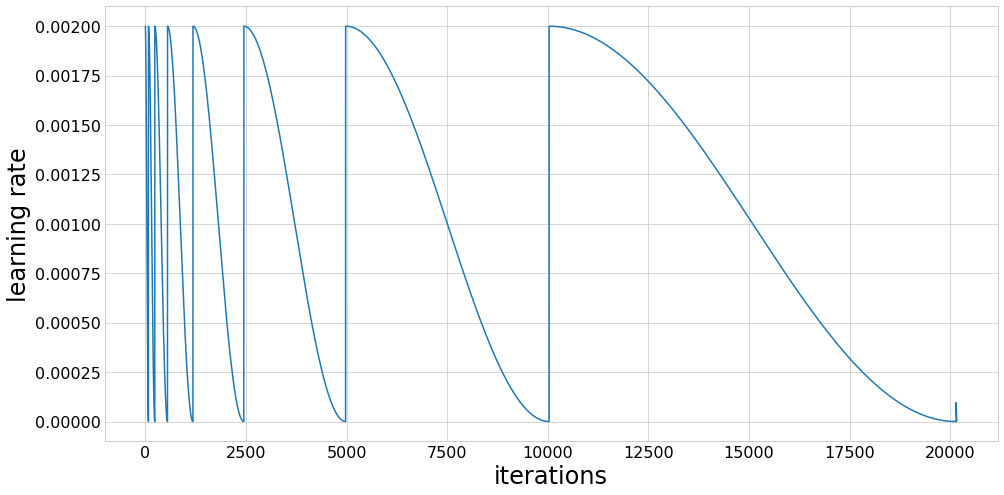

Fold took 325.030s

Training model 9 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.453699). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.227267). Check your callbacks.
  % delta_t_median)


1 New best found: 4.007644238881767e-05
2 New best found: 3.6247796501265836e-05
3 New best found: 3.581095333502162e-05
4 New best found: 3.5479601548286156e-05
5 New best found: 3.471188838011585e-05
6 New best found: 3.425449178757844e-05
7 New best found: 3.409766585828038e-05
11 New best found: 3.3842685633862855e-05
12 New best found: 3.3689043487538585e-05
13 New best found: 3.32931385593838e-05
14 New best found: 3.315226896229433e-05
15 New best found: 3.3120440613129175e-05
22 New best found: 3.309895100683207e-05
24 New best found: 3.309586274554022e-05
25 New best found: 3.267043978557922e-05
26 New best found: 3.259787132992642e-05
27 New best found: 3.2596874276350715e-05
28 New best found: 3.256114701071055e-05
29 New best found: 3.254109675472137e-05
30 New best found: 3.250202995695872e-05
31 New best found: 3.249948941229377e-05
50 New best found: 3.237926083238563e-05
51 New best found: 3.235764657729305e-05
52 New best found: 3.2331439718836916e-05
53 New best found

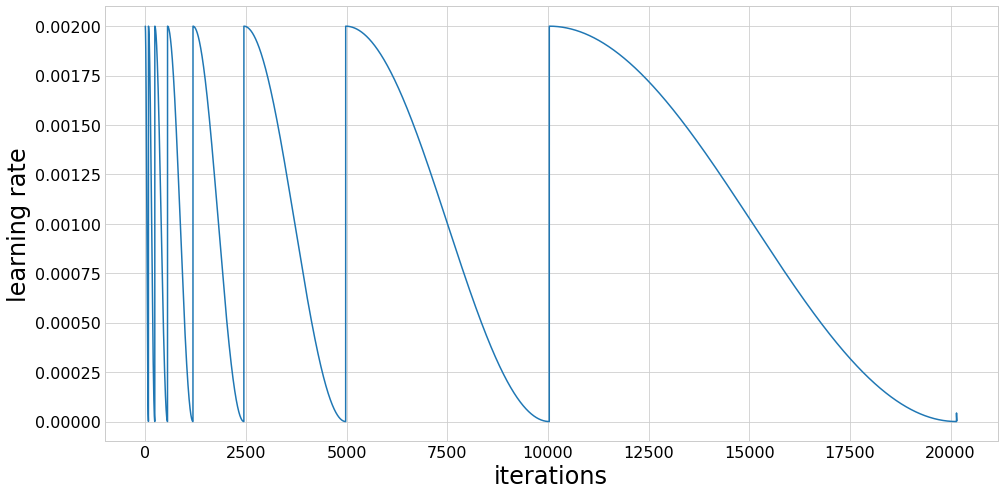

Fold took 315.169s

Training model 10 / 10
Using cosine LR annealing


/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.491745). Check your callbacks.
  % delta_t_median)
/home/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.246347). Check your callbacks.
  % delta_t_median)


1 New best found: 4.00012282096649e-05
2 New best found: 3.595971735908027e-05
3 New best found: 3.5214438911893957e-05
4 New best found: 3.500933630054564e-05
5 New best found: 3.3946090029891606e-05
6 New best found: 3.3804271576471e-05
7 New best found: 3.356033011978161e-05
10 New best found: 3.312197692742198e-05
11 New best found: 3.291276617383896e-05
12 New best found: 3.278688504986856e-05
13 New best found: 3.262660849173121e-05
14 New best found: 3.2506242433562005e-05
21 New best found: 3.238127704306465e-05
24 New best found: 3.228332465610611e-05
25 New best found: 3.2039622292572536e-05
27 New best found: 3.192633126259626e-05
28 New best found: 3.1912288099583885e-05
29 New best found: 3.185962743685614e-05
30 New best found: 3.1847409006616724e-05
45 New best found: 3.1826450134159096e-05
50 New best found: 3.167531624722866e-05
54 New best found: 3.1528556518505054e-05
55 New best found: 3.147316270519457e-05
58 New best found: 3.146898636384139e-05
59 New best found:

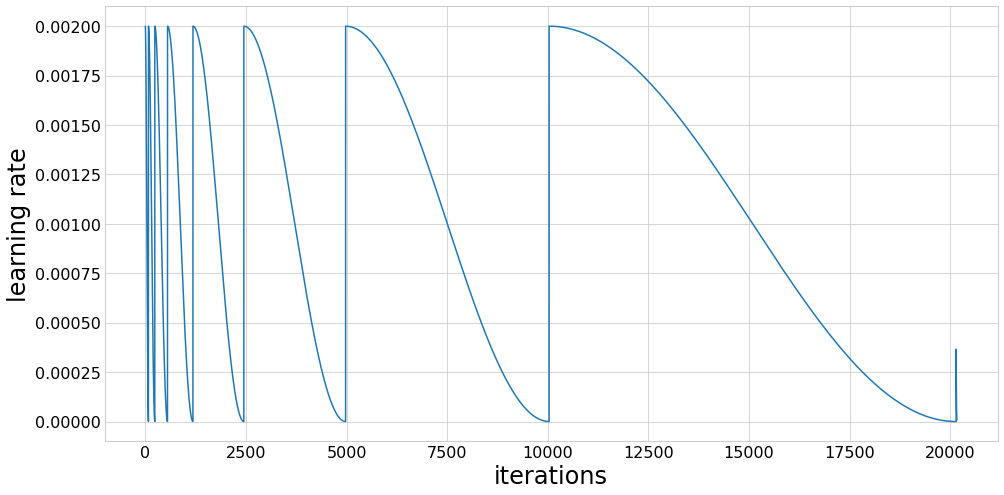

Fold took 328.634s


______________________________________
Training finished
Cross-validation took 3945.414s 


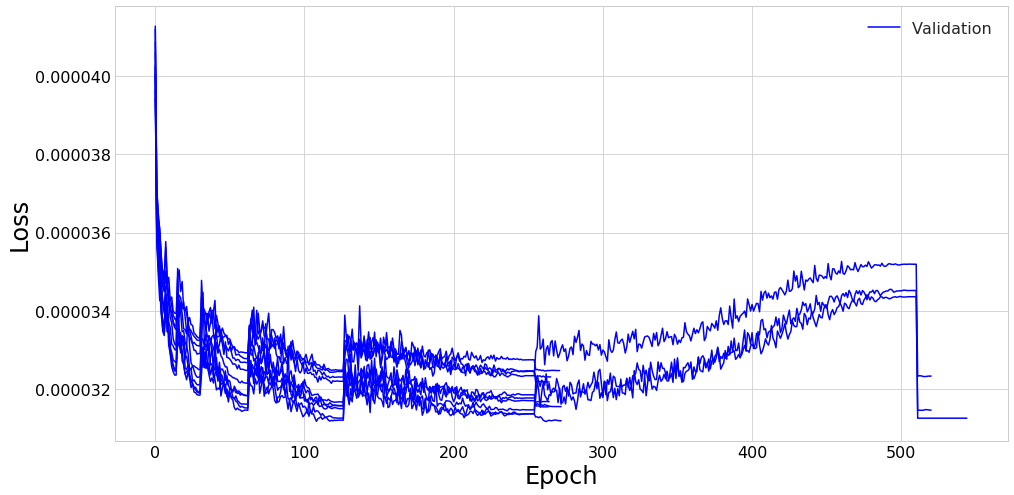

Mean loss = 3.18e-05 +- 1e-07
Mean wAUC = 0.0635 +- 0.0006
Mean AUC = 0.0991 +- 0.0007
Mean AMS = 3.86 +- 0.09
Mean cut = 0.955 +- 0.006
______________________________________



<Figure size 432x288 with 0 Axes>

In [9]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

## Construct ensemble

In [10]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [11]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 9 with loss = 3.117366624770862e-05
Model 1 is 0 with loss = 3.125911436380725e-05
Model 2 is 5 with loss = 3.1447452009888366e-05
Model 3 is 7 with loss = 3.1546480388578735e-05
Model 4 is 4 with loss = 3.155848266589391e-05
Model 5 is 8 with loss = 3.1666582424077206e-05
Model 6 is 2 with loss = 3.214986273669638e-05
Model 7 is 1 with loss = 3.2289744753043756e-05
Model 8 is 3 with loss = 3.231226001807954e-05
Model 9 is 6 with loss = 3.246362103863301e-05


## Response on validation data without TTA

In [12]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [13]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0019628464713692664s per sample

Predicting fold 2 out of 10
Prediction took 0.00035038578286767004s per sample

Predicting fold 3 out of 10
Prediction took 0.00035473719015717504s per sample

Predicting fold 4 out of 10
Prediction took 0.0003482663616538048s per sample

Predicting fold 5 out of 10
Prediction took 0.0003516536273062229s per sample

Predicting fold 6 out of 10
Prediction took 0.0003546140156686306s per sample

Predicting fold 7 out of 10
Prediction took 0.00036116554588079455s per sample

Predicting fold 8 out of 10
Prediction took 0.0003512075312435627s per sample

Predicting fold 9 out of 10
Prediction took 0.0003450459949672222s per sample

Predicting fold 10 out of 10
Prediction took 0.000351807314902544s per sample



In [14]:
val_df = convert_to_df(val_fy.source)

50000 candidates loaded


In [15]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df.gen_target, val_df.pred_class),
                                                           roc_auc_score(val_df.gen_target, val_df.pred_class, sample_weight=val_df.gen_weight)))

Testing ROC AUC: unweighted 0.9031200096488461, weighted 0.9357572717967299


Best cut at 0.9617763323946161 corresponds to AMS of 3.8207058467651516
Maximum AMS for data is 3.888276776980816 at cut of 0.9565931558609009
CPU times: user 26.9 s, sys: 0 ns, total: 26.9 s
Wall time: 26.9 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


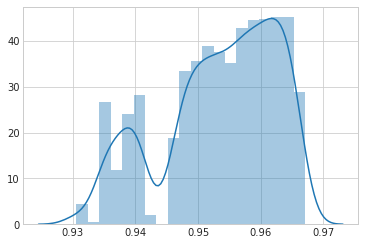

In [16]:
%%time
cut_kde = kde_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.9534133 corresponds to AMS of 3.822365817309855
Maximum AMS for data is 3.888276776980816 at cut of 0.9565931558609009
CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 111 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


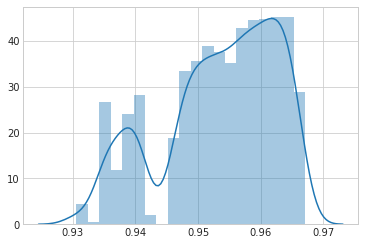

In [17]:
%%time
cut_mean = mean_optimise_cut(val_df, top_perc=0.05, br=10, w_factor=250000/50000)

## Response on validation data with TTA

In [18]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [19]:
fold_ensemble_predict(ensemble, weights, val_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005858359759300947s per sample

Predicting fold 2 out of 10
Prediction took 0.00597399320974946s per sample

Predicting fold 3 out of 10
Prediction took 0.005848450871556997s per sample

Predicting fold 4 out of 10
Prediction took 0.00581788524389267s per sample

Predicting fold 5 out of 10
Prediction took 0.005893148749321699s per sample

Predicting fold 6 out of 10
Prediction took 0.005917848028242588s per sample

Predicting fold 7 out of 10
Prediction took 0.005958883657306433s per sample

Predicting fold 8 out of 10
Prediction took 0.005890857905894518s per sample

Predicting fold 9 out of 10
Prediction took 0.005936236403882503s per sample

Predicting fold 10 out of 10
Prediction took 0.005976640042662621s per sample



In [20]:
val_df_tta = convert_to_df(val_fy.source, pred_name='pred_TTA')

50000 candidates loaded


In [21]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class),
                                                           roc_auc_score(val_df_tta.gen_target, val_df_tta.pred_class, sample_weight=val_df_tta.gen_weight)))

Testing ROC AUC: unweighted 0.903183920856792, weighted 0.9357684974684244


Best cut at 0.9605369415727105 corresponds to AMS of 3.8881281111082284
Maximum AMS for data is 3.912279321555843 at cut of 0.9606141448020935
CPU times: user 26.4 s, sys: 0 ns, total: 26.4 s
Wall time: 26.4 s


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


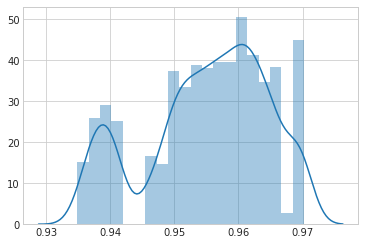

In [22]:
%%time
cut_kde_tta = kde_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

Mean cut at 0.955117 corresponds to AMS of 3.8885799835768804
Maximum AMS for data is 3.912279321555843 at cut of 0.9606141448020935
CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 105 ms


/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


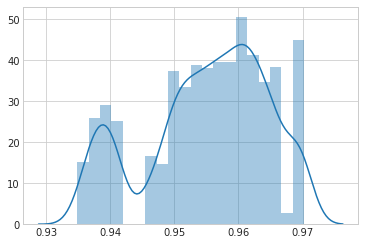

In [23]:
%%time
cut_mean_tta = mean_optimise_cut(val_df_tta, top_perc=0.05, br=10, w_factor=250000/50000)

# Test scoring - Without TTA

In [24]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [25]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0003568764890459451s per sample

Predicting fold 2 out of 10
Prediction took 0.00034873581582849675s per sample

Predicting fold 3 out of 10
Prediction took 0.0003525991735810583s per sample

Predicting fold 4 out of 10
Prediction took 0.0003475941431115974s per sample

Predicting fold 5 out of 10
Prediction took 0.0003538731908256357s per sample

Predicting fold 6 out of 10
Prediction took 0.0003544963764873418s per sample

Predicting fold 7 out of 10
Prediction took 0.000350809113884514s per sample

Predicting fold 8 out of 10
Prediction took 0.00035214114358479324s per sample

Predicting fold 9 out of 10
Prediction took 0.00035223782672123475s per sample

Predicting fold 10 out of 10
Prediction took 0.0003552540002221411s per sample

CPU times: user 3min 24s, sys: 20.9 s, total: 3min 45s
Wall time: 3min 13s


In [26]:
score_test_data(test_fy.source, cut_kde)

Public:Private AMS: 3.656147291314247 : 3.7294233612296264


(3.656147291314247, 3.7294233612296264)

In [27]:
score_test_data(test_fy.source, cut_mean)

Public:Private AMS: 3.777797326757156 : 3.7832009366522446


(3.777797326757156, 3.7832009366522446)

# Test scoring - With TTA

In [28]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), reflect_z=False,
                             input_pipe=None, rot_mult=8)

Augmenting via phi rotations
Augmenting via y flips
Total augmentation multiplicity is 16


In [29]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, pred_name='pred_TTA', ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.005709059191562913s per sample

Predicting fold 2 out of 10
Prediction took 0.005690287734703584s per sample

Predicting fold 3 out of 10
Prediction took 0.005736694174530831s per sample

Predicting fold 4 out of 10
Prediction took 0.005850016134300015s per sample

Predicting fold 5 out of 10
Prediction took 0.00570787070915103s per sample

Predicting fold 6 out of 10
Prediction took 0.005703822312639518s per sample

Predicting fold 7 out of 10
Prediction took 0.005723979120972482s per sample

Predicting fold 8 out of 10
Prediction took 0.005772983466901562s per sample

Predicting fold 9 out of 10
Prediction took 0.005992913070795211s per sample

Predicting fold 10 out of 10
Prediction took 0.005849568149515174s per sample

CPU times: user 57min 43s, sys: 4min 32s, total: 1h 2min 15s
Wall time: 52min 55s


In [30]:
score_test_data(test_fy.source, cut_kde_tta, pred_name='pred_TTA')

Public:Private AMS: 3.665108308753792 : 3.7586348498566275


(3.665108308753792, 3.7586348498566275)

In [31]:
score_test_data(test_fy.source, cut_mean_tta, pred_name='pred_TTA')

Public:Private AMS: 3.7796891737459055 : 3.7749889155906007


(3.7796891737459055, 3.7749889155906007)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)